In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import csv
import pickle
import os
from collections import Counter, deque
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Optional
from sklearn.model_selection import train_test_split

In [3]:
!sudo apt install erlang
!erl -noshell -s c c drive/MyDrive/harp/tok -s init stop # Make sure to adjust file paths
!erl -noshell -s c c drive/MyDrive/harp/pprint -s init stop # Make sure to adjust file paths

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  erlang-asn1 erlang-base erlang-common-test erlang-crypto erlang-debugger
  erlang-dev erlang-dialyzer erlang-diameter erlang-edoc erlang-eldap
  erlang-erl-docgen erlang-et erlang-eunit erlang-examples erlang-ftp
  erlang-inets erlang-jinterface erlang-megaco erlang-mnesia erlang-mode
  erlang-observer erlang-odbc erlang-os-mon erlang-parsetools
  erlang-public-key erlang-reltool erlang-runtime-tools erlang-snmp erlang-src
  erlang-ssh erlang-ssl erlang-syntax-tools erlang-tftp erlang-tools erlang-wx
  erlang-xmerl javascript-common libjs-jquery libjs-jquery-metadata
  libjs-jquery-tablesorter libsctp1 libwxbase3.0-0v5 libwxgtk3.0-gtk3-0v5
Suggested packages:
  erlang-manpages erlang-doc xsltproc fop apache2 | lighttpd | httpd
  lksctp-tools
The following NEW packages will be installed:
  erlang erlang-asn1 erlang-base erlang-common-test

In [4]:
!pip3 install import_ipynb
import import_ipynb

import drive.MyDrive.harp.Common_functions as Common_functions # Make sure to adjust file paths
import drive.MyDrive.harp.Finder_func      as Finder_func # Make sure to adjust file paths

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.4 MB/s eta 0:00:00
importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Common_functions.ipynb
Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
erlang is already the newest version (1:22.2.7+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Finder_func.ipynb


In [5]:
def cut_snippet(code,positions):
    before_snippets = []
    for position in positions:
        before_snippet_line = code.splitlines()[:position[0][0]]
        before_snippet      = '\n'.join(before_snippet_line)
        before_snippets.append(before_snippet)
        #snippet_lines = code.splitlines()[position[0][0]:position[1][0]+1]
        #snippet       = '\n'.join(snippet_lines)
    return (code, *before_snippets)

In [6]:
def create_tags(chunks, snippet_positions, snippet_type=1):
    tags = [snippet_type if i in snippet_positions else 0 for i, _ in enumerate(chunks)]
    return tags

In [7]:
# the value of `initialize` determines the mode of running: only initialization or only training
initialize_anyway = False # <-- can be set

if initialize_anyway:
    initialize = True
else:
    initialize = False
    try:
        with open(os.path.join(Common_functions.parameter_path,"tokenized_codes_idx.dump"),'rb') as tc:
            tokenized_codes_idx=pickle.load(tc)
        with open(os.path.join(Common_functions.parameter_path,"preprocessed_tags.dump"),'rb') as t:
            preprocessed_tags=pickle.load(t)

    except FileNotFoundError:
        initialize = True

In [8]:
if initialize:
    #LOAD DATA
    print('Start: loading')
    codes = []
    line_count = 0
    with open(os.path.join(Common_functions.data_path, 'context.csv'),'r') as f:
        csv_reader = csv.reader(f,delimiter='~', quoting=csv.QUOTE_ALL)
        while True:
            try: row = next(csv_reader)
            except StopIteration as e: break
            else:
                code_string = row[0]
                #positions.append([])
                position = []

                i = 1
                while True:
                    try:
                        fr_row, fr_col = int(row[i])-1,   int(row[i+1])
                        to_row, to_col = int(row[i+2])-1, int(row[i+3])
                    except IndexError:
                        break
                    else:
                        position.append(((fr_row,fr_col),(to_row,to_col)))
                        #position.append(position)
                        i -=- 5
                codes.append(cut_snippet(code_string,position))
            line_count -=- 1
            if line_count % 25000 == 0:
                print(line_count)
                #break
    print('Done: loading', len(codes), 'files')


    #TOKENIZE CODES
    tokenized_codes, snippet_positions = deque(), deque()
    runs = 50
    for i in range(runs):
        fr = i*(len(codes)//runs)
        to = (i+1)*(len(codes)//runs) if i+1 < runs else len(codes)
        print('Start: tokenizing, round:', i+1, fr, to)
        codes_chunk = codes[fr:to]
        tokenized_data = Common_functions.tokenize_code_pairs(codes_chunk, chunk_size=100, file_id='finder')
        print('End: tokenizing')

        print('Start: processing tokneized tokens')
        while tokenized_data:
            tokenized_code, *before_snippets = tokenized_data.popleft()
            tokenized_code = Common_functions.process_tokenized_code(tokenized_code, insert_beos=False, process_vars_by_chunk=True)[0]
            tokenized_codes.append(tokenized_code)
            position_to_append = deque()
            for before_snippet in before_snippets:
                position_to_append.append(before_snippet.count(('dot',None)))
            snippet_positions.append(position_to_append)
        print('Done: processing tokneized tokens')

In [9]:
if initialize:
    #SEPARATE CODE TO CHUNKS
    print('Start: separating code to chunks and tagging')
    #separated_codes = [Finder_func.separate_code(tokenized_code) for tokenized_code in tokenized_codes]
    separated_codes = deque()
    while tokenized_codes:
        tokenized_code = tokenized_codes.popleft()
        separated_codes.append(Finder_func.separate_code(tokenized_code))
    tags = [create_tags(separated_code, snippet_position) for separated_code, snippet_position in zip(separated_codes, snippet_positions)]
    print('Done: separating code to chunks and tagging')

In [10]:
if initialize:
    j = 1
    for elem in zip(tags[j], separated_codes[j]):
        for x in elem:
            print(x)

In [11]:
if initialize:
    token_counter = Counter()

    for separated_code in separated_codes:
        for chunk in separated_code:
            token_counter.update(Counter(chunk))

    word2index_finder = {token : i+1 for i, token in enumerate(Common_functions.counter_to_list(token_counter))}
    word2index_finder['PAD'] = 0
    del token_counter
    #word2index_finder['OOV'] = 1

    Common_functions.dict_to_csv(os.path.join(Common_functions.parameter_path,'word2index_finder.csv'), word2index_finder)
else:
    word2index_finder = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'word2index_finder.csv'), eval_value=True, eval_key=False)

In [12]:
print(len(word2index_finder), word2index_finder)

508 {'comma': 1, '[': 2, ']': 3, '(': 4, ')': 5, '-': 6, '=': 7, 'true': 8, 'false': 9, '{': 10, '}': 11, '->': 12, ';': 13, 'integer5': 14, 'integer6': 15, 'integer4': 16, 'integer3': 17, 'integer7': 18, 'integer8': 19, 'integer2': 20, 'integer9': 21, 'integer10': 22, ':': 23, 'integer1': 24, 'integer11': 25, 'integer12': 26, 'integer13': 27, 'integer14': 28, 'integer15': 29, 'integer0': 30, 'integer16': 31, 'integer17': 32, 'integer18': 33, 'integer19': 34, 'integer20': 35, 'integer21': 36, 'integer22': 37, 'element': 38, 'lists': 39, 'integer23': 40, 'hd': 41, 'integer24': 42, 'integer25': 43, 'integer26': 44, 'integer27': 45, 'integer28': 46, 'var0': 47, 'integer29': 48, 'var1': 49, 'integer30': 50, 'integer31': 51, 'var2': 52, 'integer32': 53, 'var3': 54, 'integer33': 55, '1': 56, 'atom0': 57, 'atom1': 58, 'integer34': 59, 'dot': 60, 'var4': 61, 'length': 62, 'integer35': 63, 'atom2': 64, '/': 65, 'integer36': 66, '<-': 67, 'list_to_tuple': 68, 'var5': 69, 'integer37': 70, 'atom3'

In [13]:
if initialize:

    tokenized_codes_idx = []

    #for tokenized_code in separated_codes:
    while separated_codes:
        tokenized_code = separated_codes.popleft()
        tokenized_code_idx = []
        for tokenized_chunk in tokenized_code:
            tokenized_chunk_idx = []
            for token in tokenized_chunk:
                try:
                    tokenized_chunk_idx.append(word2index_finder[token])
                except KeyError:
                    assert False
                    #tokenized_chunk_idx.append(word2index_finder['OOV'])
            tokenized_code_idx.append(tokenized_chunk_idx)
        tokenized_codes_idx.append(tokenized_code_idx)

In [14]:
if initialize:
    MAX_LENGTH_CODE  = len(max(tokenized_codes_idx, key=len))
    MAX_LENGTH_CHUNK = max(len(max(preprocessed_code_idx, key=len)) for preprocessed_code_idx in tokenized_codes_idx)
    print(MAX_LENGTH_CODE)
    print(MAX_LENGTH_CHUNK)

    parameters = {'MAX_LENGTH_CODE'  : MAX_LENGTH_CODE, 
                  'MAX_LENGTH_CHUNK' : MAX_LENGTH_CHUNK}
    Common_functions.dict_to_csv(os.path.join(Common_functions.parameter_path,'parameters_finder.csv'), parameters)
else:
    parameters_finder = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'parameters_finder.csv'), eval_value=True, eval_key=False)

    MAX_LENGTH_CODE  = parameters_finder['MAX_LENGTH_CODE']
    MAX_LENGTH_CHUNK = parameters_finder['MAX_LENGTH_CHUNK']

In [15]:
if initialize:
    preprocessed_tags = pad_sequences(tags, maxlen=MAX_LENGTH_CODE, padding='post', dtype='int8')
    with open(os.path.join(Common_functions.parameter_path,'preprocessed_tags.dump'),'wb') as pt:
        pickle.dump(preprocessed_tags,pt)
    del tags, preprocessed_tags

    for i in range(len(tokenized_codes_idx)):
        tokenized_codes_idx[i] = pad_sequences(tokenized_codes_idx[i], maxlen=MAX_LENGTH_CHUNK, padding='post', value=0, dtype='int16')
    tokenized_codes_idx = pad_sequences(tokenized_codes_idx, maxlen=MAX_LENGTH_CODE, padding='post', value=Finder_func.empty_line(MAX_LENGTH_CHUNK, word2index_finder), dtype='int16')
    with open(os.path.join(Common_functions.parameter_path,'tokenized_codes_idx.dump'),'wb') as pc:
        pickle.dump(tokenized_codes_idx,pc)
    del tokenized_codes_idx

In [16]:
if initialize:
    stop_execution # Throws an error on purpose to spare Google Colab RAM

#MODEL

In [17]:
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Bidirectional, TimeDistributed, Embedding, Activation, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf

In [20]:
def compile_functional(MAX_LENGTH_CODE : int, MAX_LENGTH_CHUNK : int, 
                       word2index_finder_len : int, num_of_tags : int, 
                       latent_dim : int, embedding_dim : int, 
                       layer_num : int = 2,
                       dropout_rate: float = 0.0,
                       concat_intermediate_repr : bool = False,
                       use_gru : bool = False, kernel_size = 5, 
                       use_dense : bool = False, use_minmax : bool = False,
                       conv_units : Optional[int] = None):
    rnn_dim     = latent_dim//layer_num
    if conv_units is None:
        conv_units  = embedding_dim//2
    dense_units = latent_dim
    ############################################################################
    inputs = Input(shape=(MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, ), name='input_layer')
    embedding  = Embedding(word2index_finder_len, embedding_dim, mask_zero=True, input_length=MAX_LENGTH_CHUNK)(inputs)
    ############################################################################
    conv_layer  = TimeDistributed(Common_functions.Conv1DMasked(conv_units, kernel_size, activation='signrelu'))
    convolution = conv_layer(embedding)
    ############################################################################
    conv_pool_avg     =  TimeDistributed(Common_functions.GlobalAveragePooling1DMasked())(convolution)
    conv_pool_min_max = (TimeDistributed(Common_functions.GlobalMaxPooling1DMasked())    (convolution)
                         if not use_minmax else
                         TimeDistributed(Common_functions.GlobalMinMaxPooling1DMasked()) (convolution))
    ############################################################################
    dense_layer_avg = TimeDistributed(Dense(dense_units, activation='tanh', name=f'dense_layer_avg'))
    dense_layer_max = TimeDistributed(Dense(dense_units, activation='tanh', name=f'dense_layer_max'))
    dense_avg       = dense_layer_avg(conv_pool_avg)
    dense_min_max   = dense_layer_max(conv_pool_min_max)
    if dropout_rate > 0.0:
        dense_avg     = Dropout(dropout_rate, name='dropout_dense_avg')   (dense_avg)
        dense_min_max = Dropout(dropout_rate, name='dropout_dense_minmax')(dense_min_max)
    ############################################################################
    rnn_layers_a = [
        (Bidirectional(LSTM(rnn_dim, return_sequences=True, dropout=dropout_rate), name=f'biRNN_a_{i+1}')
         if not use_gru else
         Bidirectional(GRU (rnn_dim, return_sequences=True, dropout=dropout_rate), name=f'biRNN_a_{i+1}'))
        for i in range(layer_num)
    ]
    rnn_layers_b = [
        (Bidirectional(LSTM(rnn_dim, return_sequences=True, dropout=dropout_rate), name=f'biRNN_b_{i+1}')
         if not use_gru else
         Bidirectional(GRU (rnn_dim, return_sequences=True, dropout=dropout_rate), name=f'biRNN_b_{i+1}'))
        for i in range(layer_num)
    ]
    rnn_avg = [
        layer_b(layer_a(conv_pool_avg))
        for layer_b, layer_a in zip(rnn_layers_b[:layer_num//2], rnn_layers_a[:layer_num//2])
    ]
    rnn_min_max = [
        layer_b(layer_a(conv_pool_min_max))
        for layer_b, layer_a in zip(rnn_layers_b[layer_num//2:], rnn_layers_a[layer_num//2:])
    ]
    ############################################################################
    if use_dense:
        concat_rnn = Concatenate()([*rnn_avg,  *rnn_min_max, dense_avg, dense_min_max])
    else:
        concat_rnn = Concatenate()([*rnn_avg,  *rnn_min_max])
    if concat_intermediate_repr:
        concat_rnn = Concatenate()([concat_rnn,conv_pool_avg,conv_pool_min_max])
    ############################################################################
    out_dense = TimeDistributed(Dense(1))(concat_rnn)
    out_act   = Activation('sigmoid')(out_dense)
    ############################################################################

    model = Model(inputs, out_act)

    model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.001),
                metrics=['accuracy'], run_eagerly=True)

    print(model.summary())

    return model

In [21]:
model = compile_functional(MAX_LENGTH_CODE, MAX_LENGTH_CHUNK, 
                           len(word2index_finder), num_of_tags=2, 
                           latent_dim=64, embedding_dim=64,
                           dropout_rate=0.2,
                           layer_num=2, concat_intermediate_repr=False, use_gru=False,
                           conv_units=128, use_dense=True, use_minmax=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 18, 782)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, 18, 782, 64)  32512       ['input_layer[0][0]']            
                                                                                                  
 time_distributed (TimeDistribu  (None, 18, 778, 128  41088      ['embedding[0][0]']              
 ted)                           )                                                                 
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 18, 128)     0           ['time_distributed[0][0]']   

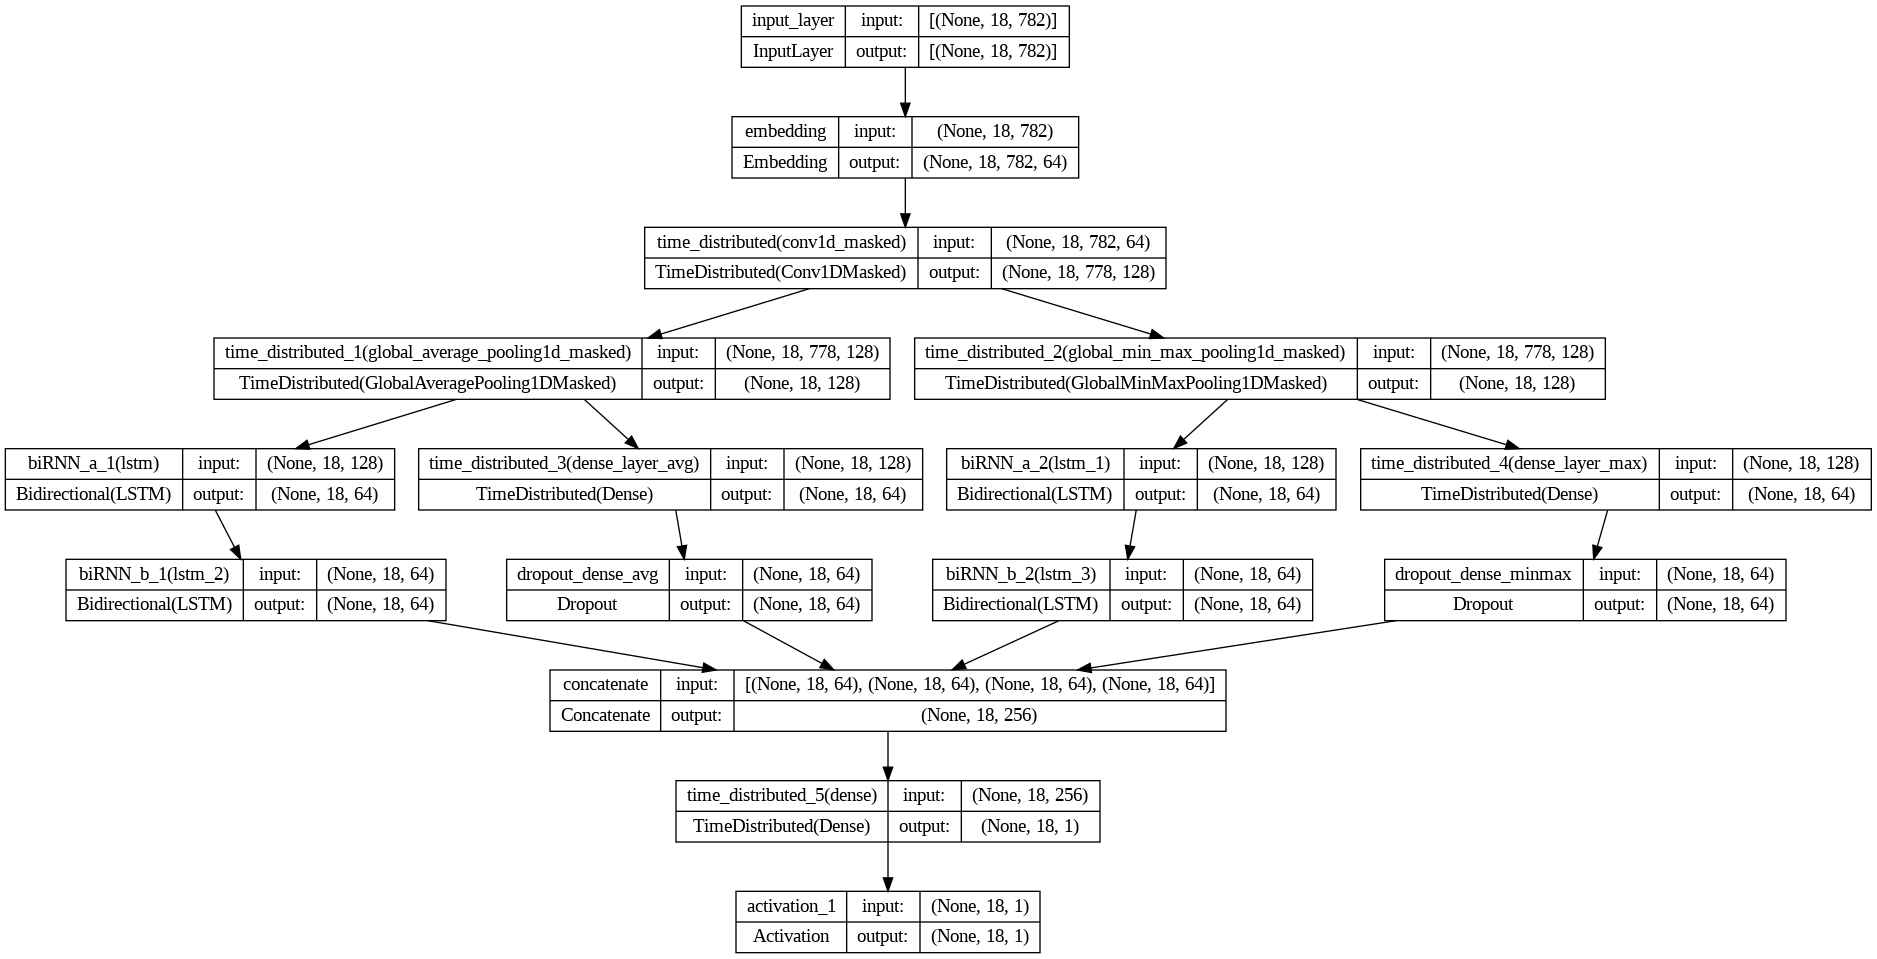

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

In [24]:
model_file_name = 'finder_model.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint(os.path.join(Common_functions.saved_model_path,model_file_name), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [25]:
#preprocessed_onehot_tags = to_categorical(preprocessed_tags, num_classes=2, dtype='int8')
#del preprocessed_tags

In [26]:
new_shape = tuple(list(preprocessed_tags.shape) + [1])
preprocessed_tags = preprocessed_tags.reshape(new_shape)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_codes_idx, preprocessed_tags, test_size=0.1, random_state=42)
del tokenized_codes_idx
del preprocessed_tags

In [28]:
model.fit(X_train, y_train, batch_size=2**6, epochs=25, verbose=1, validation_split=0.1, callbacks=[es, mc])

Epoch 1/25


1266/1266 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9762
Epoch 1: val_loss improved from inf to 0.02889, saving model to drive/MyDrive/tidierpp/saved_models/finder_IV.h5
1266/1266 [==============================] - 842s 651ms/step - loss: 0.0562 - accuracy: 0.9762 - val_loss: 0.0289 - val_accuracy: 0.9887
Epoch 2/25
1266/1266 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9884
Epoch 2: val_loss improved from 0.02889 to 0.02713, saving model to drive/MyDrive/tidierpp/saved_models/finder_IV.h5
1266/1266 [==============================] - 800s 632ms/step - loss: 0.0285 - accuracy: 0.9884 - val_loss: 0.0271 - val_accuracy: 0.9893
Epoch 3/25
1266/1266 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9896
Epoch 3: val_loss improved from 0.02713 to 0.02473, saving model to drive/MyDrive/tidierpp/saved_models/finder_IV.h5
1266/1266 [==============================] - 805s 636ms/step - loss: 0.0257 - accuracy: 0.9896 -

In [29]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 66s 211ms/step - loss: 0.0231 - accuracy: 0.9909


[0.023145856335759163, 0.9909165501594543]